In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandera.pandas as pa
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np


pd.set_option('display.float_format', '{:.2f}'.format)

<h2 style="text-align: center">DATA LOADING</h2>

In [161]:
DATA_PATH = "../data/online_retail_II.xlsx"

df = pd.read_excel(DATA_PATH, sheet_name=0, dtype={"Customer ID": str})

In [162]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085,United Kingdom


In [163]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[us]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  str           
 7   Country      525461 non-null  str           
dtypes: datetime64[us](1), float64(1), int64(1), object(3), str(2)
memory usage: 32.1+ MB


In [164]:
df.describe()

,Quantity,InvoiceDate,Price
count,525461.00,525461,525461.00
mean,10.34,2010-06-28 11:37:36.845018,4.69
min,-9600.00,2009-12-01 07:45:00,-53594.36
25%,1.00,2010-03-21 12:20:00,1.25
50%,3.00,2010-07-06 09:51:00,2.10
75%,10.00,2010-10-15 12:45:00,4.21
max,19152.00,2010-12-09 20:01:00,25111.09
std,107.42,NaN,146.13


In [165]:
df.describe(include=['object', 'str'])

,Invoice,StockCode,Description,Customer ID,Country
count,525461,525461,522533,417534,525461
unique,28816,4632,4681,4383,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,14911,United Kingdom
freq,675,3516,3549,5710,485852


In [166]:
# schema validation before data cleaning (so nulls are allowed)


schema_raw = pa.DataFrameSchema({
    "Customer ID": pa.Column(str, nullable=True),
    "Invoice": pa.Column(object, nullable=True),
    "Quantity": pa.Column(int, nullable=True),
    "Price": pa.Column(float, nullable=True),
    "InvoiceDate": pa.Column("datetime64[us]", nullable=True),
    "Country": pa.Column(str, nullable=True),
    # "Description", "StockCode" - ignore because they are object types
})
schema_raw.validate(df)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom


<h2 style="text-align: center">DATA CLEANING</h2>

In [167]:
df[df["Customer ID"].isna()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


In [168]:
df[df["Quantity"] < 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592,United Kingdom


In [169]:
df[df["Price"] < 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [170]:
df["Invoice"] = df["Invoice"].astype("str")

df[df["Invoice"].str.match("^\\d{6}$") == False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329,United Kingdom


In [171]:
df["Invoice"].str.replace("[0-9]", "", regex=True).unique()

# unique Invoice prefixes values

<StringArray>
['', 'C', 'A']
Length: 3, dtype: str

In [172]:
df[df["Invoice"].str.startswith("A", na = False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [173]:
df["StockCode"] = df["StockCode"].astype("str")

df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique()

# this regex is for StockCode values that are not 5 digits or 5 digits followed by letters, which are the valid formats for StockCode. 
# So it reveals all the anomalous/non-standard stock codes

<StringArray>
[        'POST',            'D',     'DCGS0058',     'DCGS0068',
          'DOT',            'M',     'DCGS0004',     'DCGS0076',
           'C2', 'BANK CHARGES',     'DCGS0003',      'TEST001',
 'gift_0001_80',     'DCGS0072', 'gift_0001_20',     'DCGS0044',
      'TEST002', 'gift_0001_10', 'gift_0001_50',    'DCGS0066N',
 'gift_0001_30',         'PADS',       'ADJUST', 'gift_0001_40',
 'gift_0001_60', 'gift_0001_70', 'gift_0001_90',    'DCGSSGIRL',
     'DCGS0006',     'DCGS0016',     'DCGS0027',     'DCGS0036',
     'DCGS0039',     'DCGS0060',     'DCGS0056',     'DCGS0059',
         'GIFT',     'DCGSLBOY',            'm',     'DCGS0053',
     'DCGS0062',     'DCGS0037',     'DCGSSBOY',    'DCGSLGIRL',
            'S',     'DCGS0069',     'DCGS0070',     'DCGS0075',
            'B',     'DCGS0041',      'ADJUST2',      '47503J ',
           'C3',       'SP1002',    'AMAZONFEE']
Length: 55, dtype: str

In [174]:
df[df["StockCode"].str.contains("^DOT")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2379,489597,DOT,DOTCOM POSTAGE,1,2009-12-01 14:28:00,647.19,NaN,United Kingdom
2539,489600,DOT,DOTCOM POSTAGE,1,2009-12-01 14:43:00,55.96,NaN,United Kingdom
2551,489601,DOT,DOTCOM POSTAGE,1,2009-12-01 14:44:00,68.39,NaN,United Kingdom
2571,489602,DOT,DOTCOM POSTAGE,1,2009-12-01 14:45:00,59.35,NaN,United Kingdom
2619,489603,DOT,DOTCOM POSTAGE,1,2009-12-01 14:46:00,42.39,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524272,538071,DOT,DOTCOM POSTAGE,1,2010-12-09 14:09:00,885.94,NaN,United Kingdom
524887,538148,DOT,DOTCOM POSTAGE,1,2010-12-09 16:26:00,547.32,NaN,United Kingdom
525000,538149,DOT,DOTCOM POSTAGE,1,2010-12-09 16:27:00,620.68,NaN,United Kingdom
525126,538153,DOT,DOTCOM POSTAGE,1,2010-12-09 16:31:00,822.94,NaN,United Kingdom


In [175]:
cleaned_df = df.copy()

In [176]:
# Actual cleaning starts:

cleaned_df["Invoice"] = cleaned_df["Invoice"].astype("str")

# filtering expression:
mask = (
    cleaned_df["Invoice"].str.match("^\\d{6}$") == True
)

cleaned_df = cleaned_df[mask]

cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom


In [177]:
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype("str")

mask = (
    (cleaned_df["StockCode"].str.match("^\\d{5}$") == True)
    | (cleaned_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True)
    | (cleaned_df["StockCode"].str.match("^PADS$") == True)

)

cleaned_df = cleaned_df[mask]

cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom


In [178]:
cleaned_df.dropna(subset=["Customer ID"], inplace=True)

In [179]:
cleaned_df.dropna(subset=["InvoiceDate"], inplace=True)

In [180]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price
count,406337.00,406337,406337.00
mean,13.62,2010-07-01 10:11:06.543287,2.99
min,1.00,2009-12-01 07:45:00,0.00
25%,2.00,2010-03-26 14:01:00,1.25
50%,5.00,2010-07-09 15:48:00,1.95
75%,12.00,2010-10-14 17:09:00,3.75
max,19152.00,2010-12-09 20:01:00,295.00
std,97.00,NaN,4.29


In [181]:
len(cleaned_df[cleaned_df["Price"] == 0])

28

In [182]:
cleaned_df = cleaned_df[cleaned_df["Price"] > 0]

In [183]:
cleaned_df = cleaned_df[cleaned_df["Quantity"] > 0]

In [184]:
cleaned_df.drop_duplicates(inplace=True)

In [185]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price
count,399566.00,399566,399566.00
mean,13.80,2010-07-01 04:58:19.365311,3.00
min,1.00,2009-12-01 07:45:00,0.00
25%,2.00,2010-03-26 13:42:00,1.25
50%,5.00,2010-07-09 10:26:00,1.95
75%,12.00,2010-10-14 14:08:00,3.75
max,19152.00,2010-12-09 20:01:00,295.00
std,97.80,NaN,4.31


In [186]:
cleaned_df["Price"].min()

np.float64(0.001)

In [187]:
# Schema validation after cleaning (so nulls are not allowed)

schema_cleaned = pa.DataFrameSchema({
    "Customer ID": pa.Column(str, nullable=False),
    "Invoice": pa.Column(str, nullable=False),
    "Quantity": pa.Column(int, pa.Check.greater_than(0), nullable=False),
    "Price": pa.Column(float, pa.Check.greater_than(0), nullable=False),
    "Description": pa.Column(object, nullable=False),
    "StockCode": pa.Column(str, nullable=False),
    "InvoiceDate": pa.Column("datetime64[us]", nullable=False),
    "Country": pa.Column(str, nullable=False),
})
schema_cleaned.validate(cleaned_df)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom


In [188]:
len(cleaned_df)/len(df)

0.7604103825022218

Finals result: Dropped about 24% of the records

<h2 style="text-align: center">FEATURE ENGINEERING</h2>

Features: Recency, Frequency, Monetary, Tenure, AOV

In [189]:
cleaned_df["SalesLineTotal"] = cleaned_df["Quantity"] * cleaned_df["Price"] # total revenue for each individual transaction row.

cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,SalesLineTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom,7.50


In [190]:
aggregated_df = cleaned_df.groupby(by="Customer ID", as_index=False) \
    .agg(
        MonetaryValue=("SalesLineTotal", "sum"),
        Frequency=("Invoice", "nunique"),
        LastInvoiceDate=("InvoiceDate", "max"),
        FirstInvoiceDate=("InvoiceDate", "min")
    )

aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,FirstInvoiceDate
0,12346,169.36,2,2010-06-28 13:53:00,2010-03-02 13:08:00
1,12347,1323.32,2,2010-12-07 14:57:00,2010-10-31 14:20:00
2,12348,221.16,1,2010-09-27 14:59:00,2010-09-27 14:59:00
3,12349,2221.14,2,2010-10-28 08:23:00,2010-04-29 13:20:00
4,12351,300.93,1,2010-11-29 15:23:00,2010-11-29 15:23:00


In [191]:
max_invoice_data = aggregated_df["LastInvoiceDate"].max()

aggregated_df["Recency"] = (max_invoice_data - aggregated_df["LastInvoiceDate"]).dt.days
aggregated_df["Tenure"] = (aggregated_df["LastInvoiceDate"] - aggregated_df["FirstInvoiceDate"]).dt.days
aggregated_df["AOV"] = aggregated_df["MonetaryValue"] / aggregated_df["Frequency"]
aggregated_df.drop(columns=["LastInvoiceDate", "FirstInvoiceDate"], inplace=True)

aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,Recency,Tenure,AOV
0,12346,169.36,2,164,118,84.68
1,12347,1323.32,2,2,37,661.66
2,12348,221.16,1,73,0,221.16
3,12349,2221.14,2,42,181,1110.57
4,12351,300.93,1,10,0,300.93


In [192]:
aggregated_df["MonetaryValue"] = np.log1p(aggregated_df["MonetaryValue"])
aggregated_df["Frequency"] = np.log1p(aggregated_df["Frequency"])
aggregated_df["Recency"] = np.log1p(aggregated_df["Recency"])
aggregated_df["Tenure"] = np.log1p(aggregated_df["Tenure"])
aggregated_df["AOV"] = np.log1p(aggregated_df["AOV"])

VISUALIZATION - MATPLOTLIB

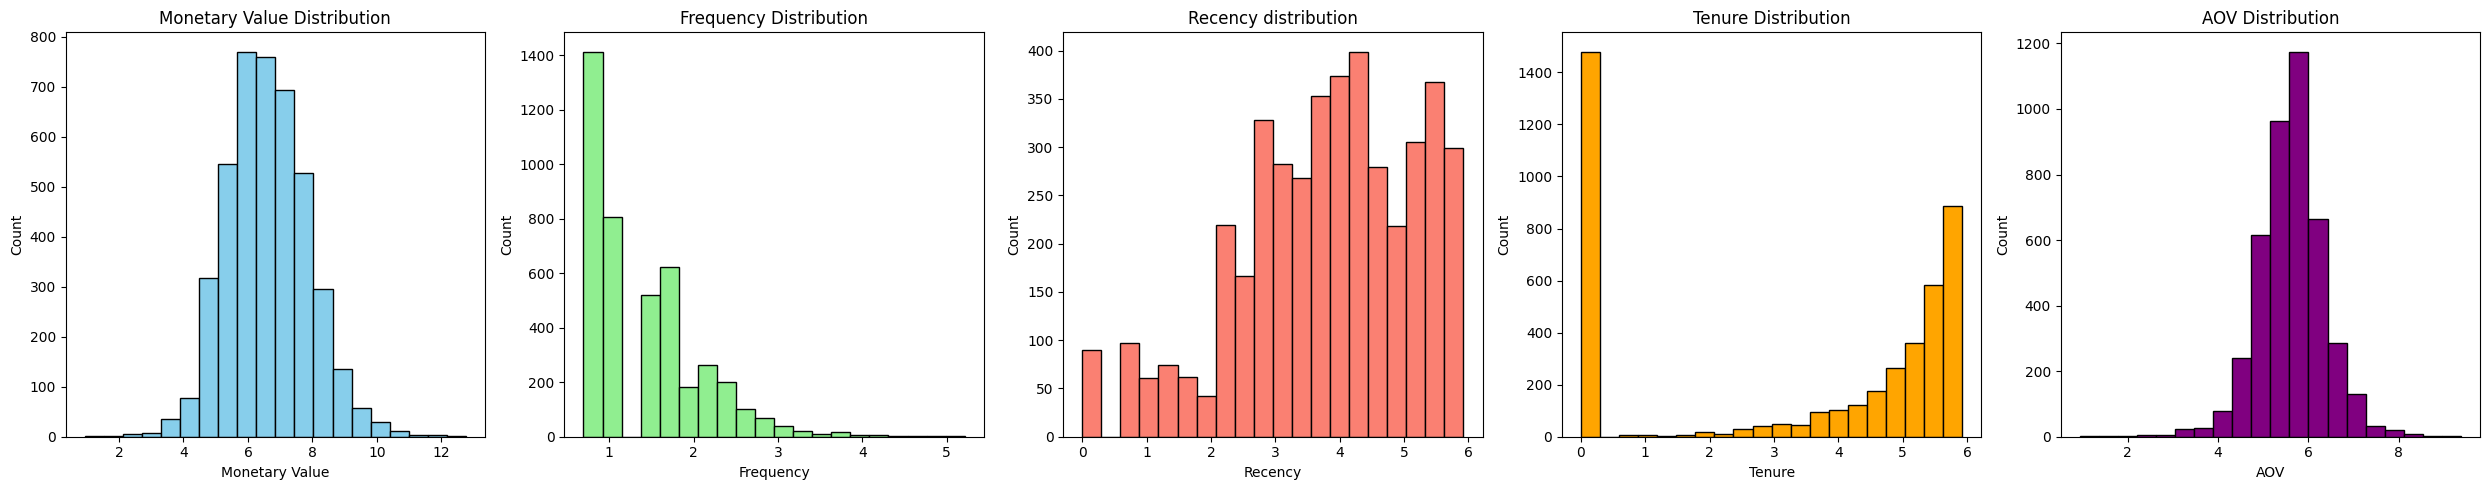

In [193]:
# shape/skewness visualization
plt.figure(figsize=(25, 5))

plt.subplot(1, 5, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=20, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 5, 2)
plt.hist(aggregated_df['Frequency'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 5, 3)
plt.hist(aggregated_df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.subplot(1, 5, 4)
plt.hist(aggregated_df['Tenure'], bins=20, color='orange', edgecolor='black')
plt.title('Tenure Distribution')
plt.xlabel('Tenure')
plt.ylabel('Count')

plt.subplot(1, 5, 5)
plt.hist(aggregated_df['AOV'], bins=20, color='purple', edgecolor='black')
plt.title('AOV Distribution')
plt.xlabel('AOV')
plt.ylabel('Count')


plt.tight_layout()
plt.show()

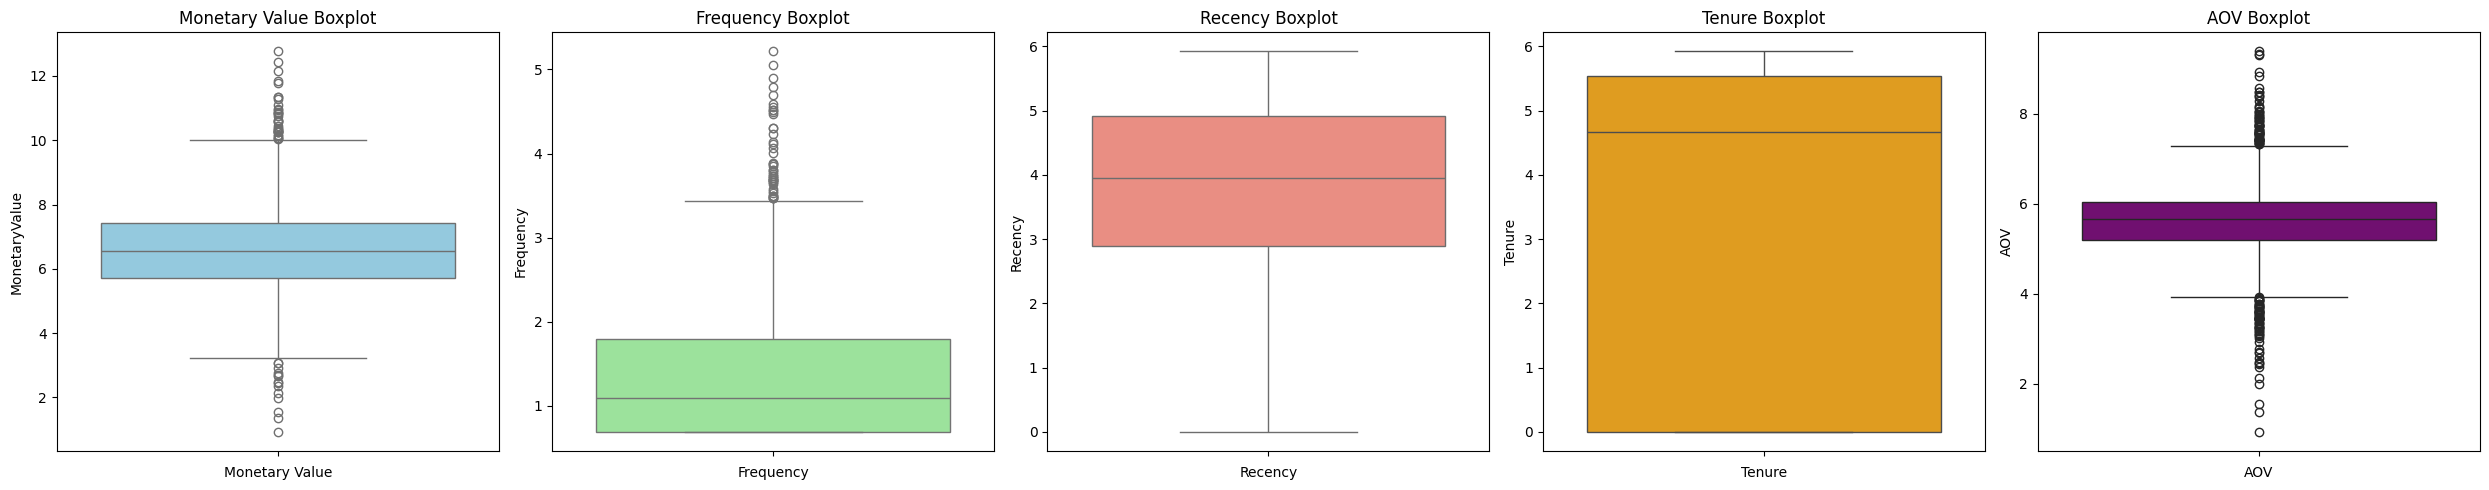

In [194]:
# outlier visualization
plt.figure(figsize=(25, 5))

plt.subplot(1, 5, 1)
sns.boxplot(data=aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 5, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 5, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.subplot(1, 5, 4)
sns.boxplot(data=aggregated_df['Tenure'], color='orange')
plt.title('Tenure Boxplot')
plt.xlabel('Tenure')

plt.subplot(1, 5, 5)
sns.boxplot(data=aggregated_df['AOV'], color='purple')
plt.title('AOV Boxplot')
plt.xlabel('AOV')

plt.tight_layout()
plt.show()


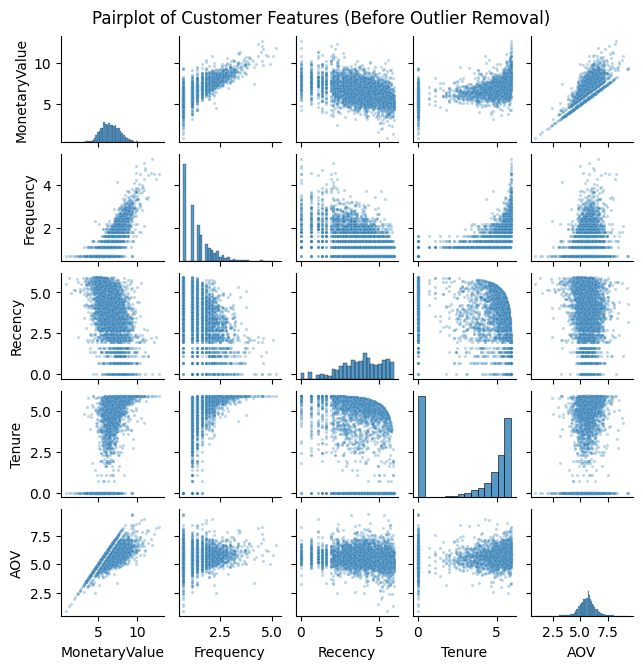

In [195]:
# more detailed visualization before outlier removal

sns.pairplot(aggregated_df[["MonetaryValue", "Frequency", "Recency", "Tenure", "AOV"]], 
             plot_kws={"alpha": 0.3, "s": 5},
             height=1.3)
plt.suptitle("Pairplot of Customer Features (Before Outlier Removal)", y=1.02)
plt.show()

<h2 style="text-align: center">OUTLIER DETECTION</h2>

In [196]:
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1


monetary_outliers_df = aggregated_df[(aggregated_df["MonetaryValue"] > (M_Q3 + 1.5 * M_IQR)) | (aggregated_df["MonetaryValue"] < (M_Q1 - 1.5 * M_IQR))].copy()

monetary_outliers_df.describe()




,MonetaryValue,Frequency,Recency,Tenure,AOV
count,48.00,48.00,48.00,48.00,48.00
mean,8.34,2.84,2.79,4.10,5.73
std,3.96,1.56,1.90,2.67,2.34
min,0.94,0.69,0.00,0.00,0.94
25%,3.03,0.69,1.55,0.00,3.03
50%,10.31,3.33,2.20,5.88,6.61
75%,10.85,4.02,5.04,5.90,7.27
max,12.76,5.21,5.92,5.92,8.92


In [197]:
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1


frequency_outliers_df = aggregated_df[(aggregated_df['Frequency'] > (F_Q3 + 1.5 * F_IQR)) 
                                      | (aggregated_df['Frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()

frequency_outliers_df.describe()



,MonetaryValue,Frequency,Recency,Tenure,AOV
count,46.00,46.00,46.00,46.00,46.00
mean,10.18,4.00,1.52,5.86,6.21
std,1.04,0.47,1.20,0.18,0.88
min,7.44,3.47,0.00,4.75,3.35
25%,9.60,3.67,0.69,5.89,5.79
50%,9.91,3.81,1.50,5.91,6.19
75%,10.81,4.30,2.08,5.91,6.63
max,12.76,5.21,5.11,5.92,8.27


In [198]:
A_Q1 = aggregated_df['AOV'].quantile(0.25)
A_Q3 = aggregated_df['AOV'].quantile(0.75)
A_IQR = A_Q3 - A_Q1

aov_outliers_df = aggregated_df[(aggregated_df['AOV'] > (A_Q3 + 1.5 * A_IQR)) 
                                | (aggregated_df['AOV'] < (A_Q1 - 1.5 * A_IQR))].copy()

In [199]:
non_outliers_df = aggregated_df[
    (~aggregated_df.index.isin(monetary_outliers_df.index)) & 
    (~aggregated_df.index.isin(frequency_outliers_df.index)) &
    (~aggregated_df.index.isin(aov_outliers_df.index))
]
non_outliers_df.describe()

,MonetaryValue,Frequency,Recency,Tenure,AOV
count,4106.00,4106.00,4106.00,4106.00,4106.00
mean,6.58,1.35,3.80,3.33,5.63
std,1.13,0.63,1.37,2.51,0.62
min,3.94,0.69,0.00,0.00,3.93
25%,5.74,0.69,2.94,0.00,5.21
50%,6.52,1.10,3.95,4.69,5.65
75%,7.38,1.79,4.87,5.53,6.02
max,10.00,3.43,5.92,5.92,7.29


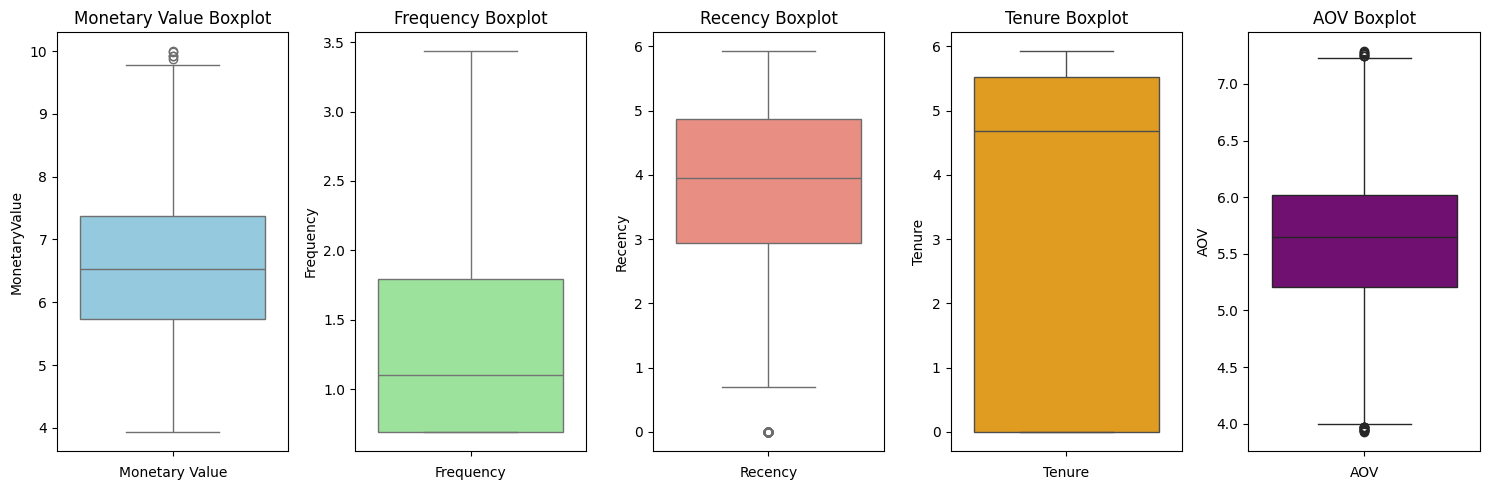

In [200]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)
sns.boxplot(data=non_outliers_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 5, 2)
sns.boxplot(data=non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 5, 3)
sns.boxplot(data=non_outliers_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.subplot(1, 5, 4)
sns.boxplot(data=non_outliers_df['Tenure'], color='orange')
plt.title('Tenure Boxplot')
plt.xlabel('Tenure')

plt.subplot(1, 5, 5)
sns.boxplot(data=non_outliers_df['AOV'], color='purple')
plt.title('AOV Boxplot')
plt.xlabel('AOV')



plt.tight_layout()
plt.show()

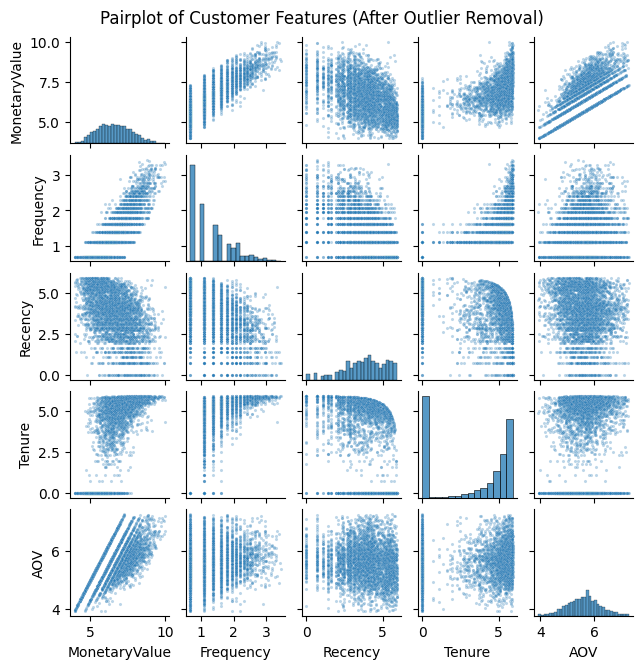

In [201]:
sns.pairplot(non_outliers_df[["MonetaryValue", "Frequency", "Recency", "Tenure", "AOV"]], 
             plot_kws={"alpha": 0.3, "s": 5},
             height=1.3)
plt.suptitle("Pairplot of Customer Features (After Outlier Removal)", y=1.02)
plt.show()

Monetary and AOV are highly colinear - It can distory K-Means Euclidean distances by double-weighting the spending dimension and AOV derives from the monetary so it should be dropped.

In [202]:
non_outliers_df = non_outliers_df.drop(columns=["AOV"])

<h2 style="text-align: center">SCALING</h2>

In [ ]:
# standardscaler because skewed data and outliers already have been handled

scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency", "Tenure"]])

scaled_data

array([[-1.27317793, -0.39344337,  0.95760353,  0.57980074],
       [ 0.53935947, -0.39344337, -1.97348082,  0.12412975],
       [-1.03853114, -1.03702856,  0.37108404, -1.32789677],
       ...,
       [-0.56877059, -1.03702856,  1.38506154, -1.32789677],
       [ 0.48649343, -0.39344337,  0.6742134 ,  0.87291564],
       [ 1.02598573,  0.41737808, -0.6629339 ,  0.7644676 ]],
      shape=(4106, 4))

In [ ]:
scaled_data_df = pd.DataFrame(
    scaled_data, 
    index=non_outliers_df.index, 
    columns=["MonetaryValue", 
             "Frequency", 
             "Recency", 
             "Tenure"]
)

scaled_data_df


,MonetaryValue,Frequency,Recency,Tenure
0,-1.27,-0.39,0.96,0.58
1,0.54,-0.39,-1.97,0.12
2,-1.04,-1.04,0.37,-1.33
3,1.00,-0.39,-0.03,0.75
4,-0.77,-1.04,-1.02,-1.33
...,...,...,...,...
4280,-0.13,0.95,-0.66,0.92
4281,-0.49,-1.04,0.30,-1.33
4282,-0.57,-1.04,1.39,-1.33
4283,0.49,-0.39,0.67,0.87


<h2 style="text-align: center">K-MEANS CLUSTERING</h2>

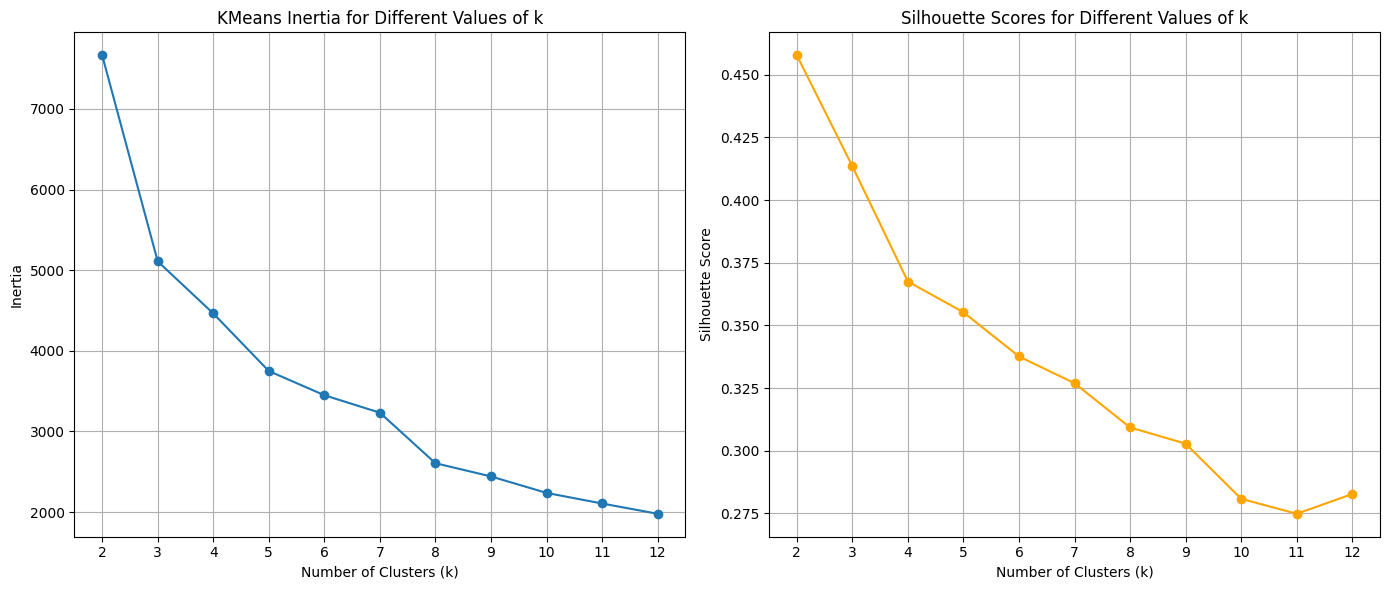

In [205]:
max_k = 12

inertia = []
silhouette_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)

    cluster_labels = kmeans.fit_predict(scaled_data_df)

    sil_score = silhouette_score(scaled_data_df, cluster_labels)

    silhouette_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()


In [206]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=300)

cluster_labels = kmeans.fit_predict(scaled_data_df)

cluster_labels



array([3, 2, 1, ..., 1, 3, 0], shape=(4106,), dtype=int32)

In [207]:
non_outliers_df["Cluster"] = cluster_labels

non_outliers_df



,Customer ID,MonetaryValue,Frequency,Recency,Tenure,Cluster
0,12346,5.14,1.10,5.11,4.78,3
1,12347,7.19,1.10,1.10,3.64,2
2,12348,5.40,0.69,4.30,0.00,1
3,12349,7.71,1.10,3.76,5.20,3
4,12351,5.71,0.69,2.40,0.00,1
...,...,...,...,...,...,...
4280,18283,6.43,1.95,2.89,5.62,3
4281,18284,6.02,0.69,4.20,0.00,1
4282,18285,5.93,0.69,5.69,0.00,1
4283,18286,7.13,1.10,4.72,5.51,3


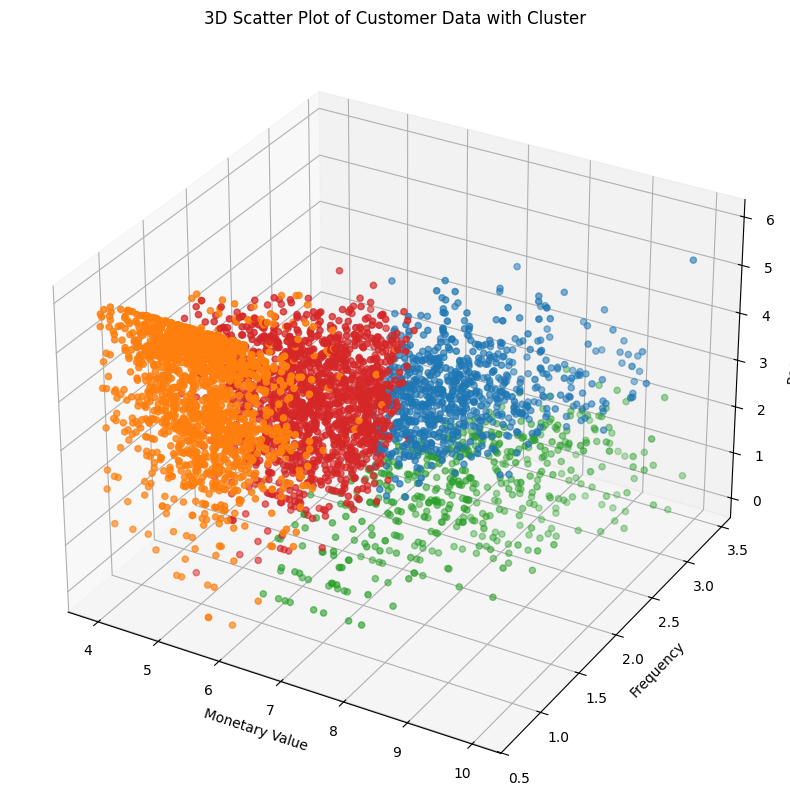

In [ ]:
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'], 
                     non_outliers_df['Frequency'], 
                     non_outliers_df['Recency'],
                     c=colors,
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data with Cluster')

plt.show()

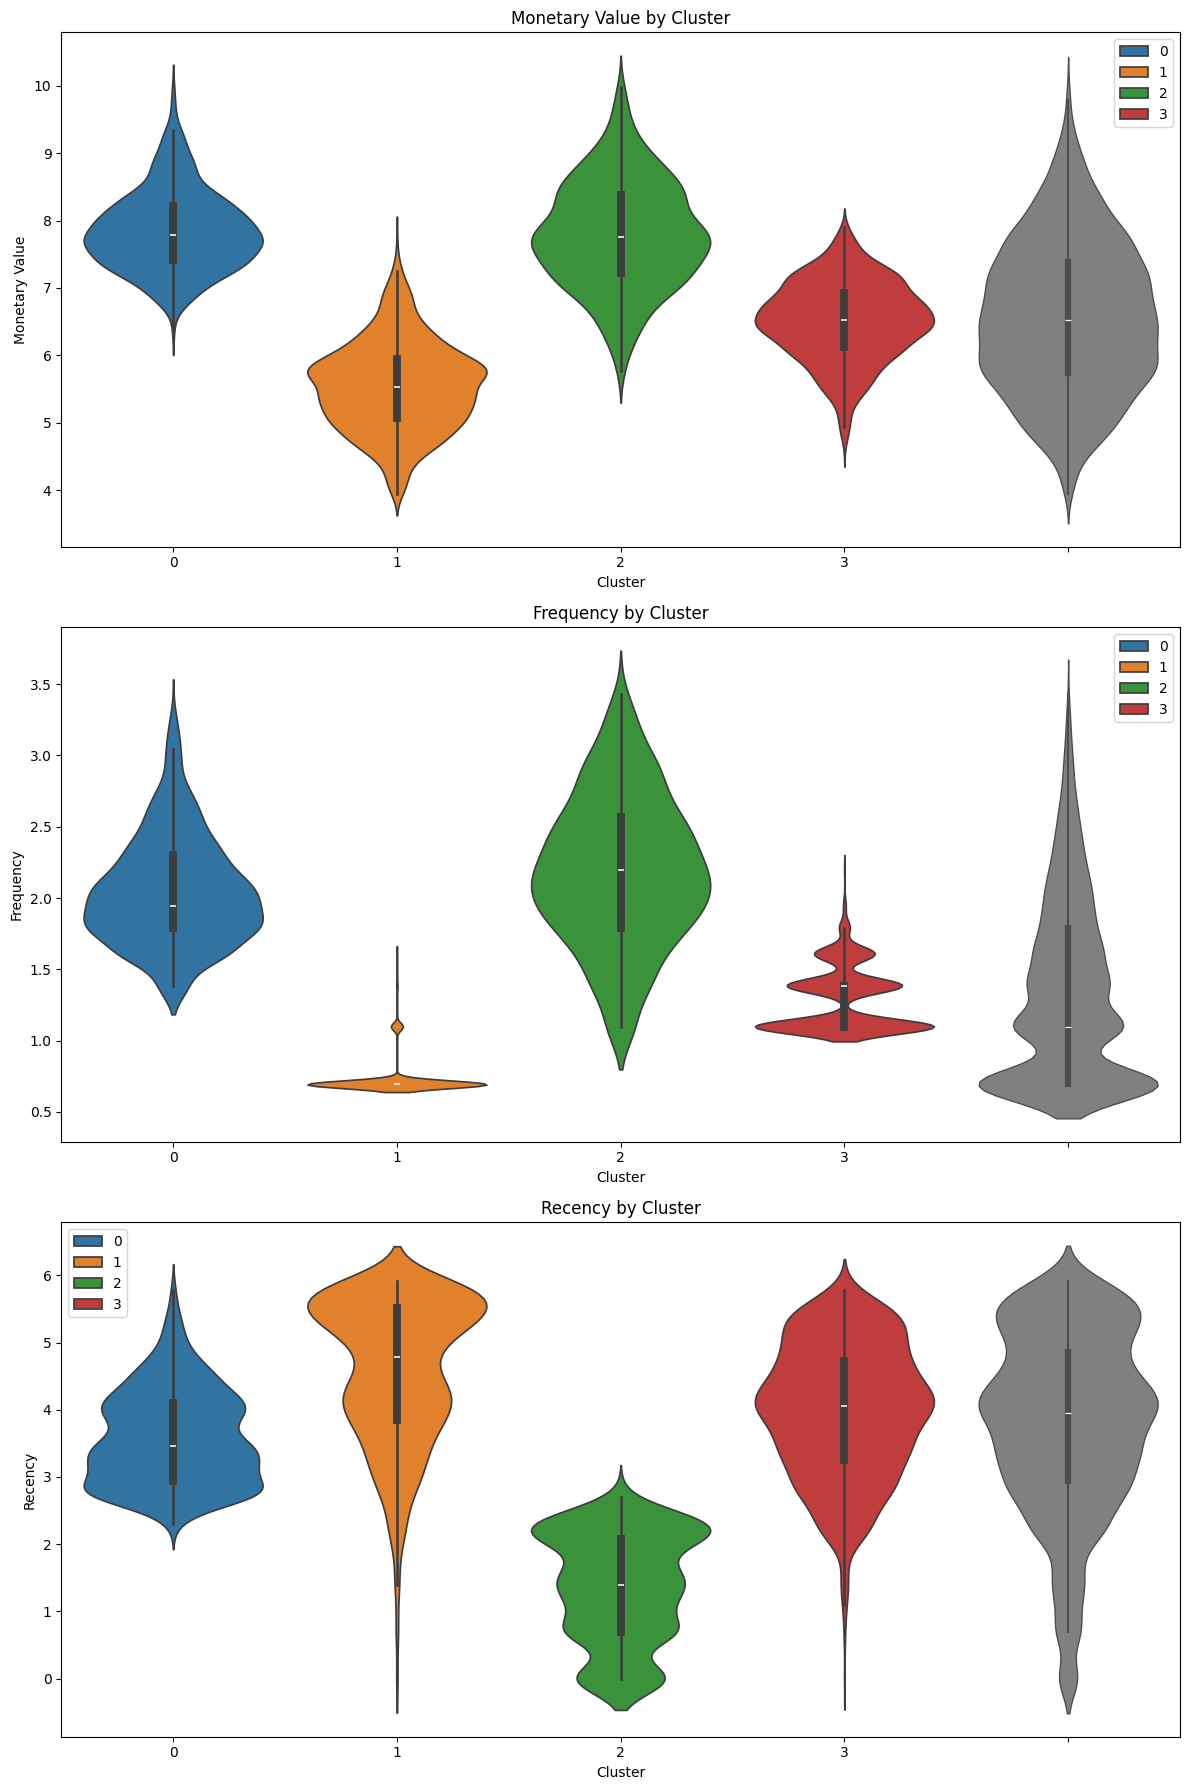

In [209]:
plt.figure(figsize=(12, 18))


plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['MonetaryValue'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')


plt.tight_layout()
plt.show()



In [210]:
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices]
recency_only_outliers = recency_outliers_df.drop(
    recency_outliers_df.index.intersection(monetary_outliers_df.index).union(
    recency_outliers_df.index.intersection(frequency_outliers_df.index))
)

monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3
recency_only_outliers["Cluster"] = -4

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, 
                                  monetary_and_frequency_outliers, recency_only_outliers])

outlier_clusters_df

,Customer ID,MonetaryValue,Frequency,Recency,Tenure,AOV,Cluster
488,13081,10.34,3.00,1.95,5.89,7.39,-1
515,13112,3.07,0.69,5.18,0.00,3.07,-1
552,13163,2.93,0.69,5.51,0.00,2.93,-1
1000,13788,1.56,0.69,4.95,0.00,1.56,-1
1065,13881,10.24,3.18,2.40,5.60,7.11,-1
...,...,...,...,...,...,...,...
4089,18012,115.30,1.00,358.00,0.00,115.30,-4
4194,18162,371.51,1.00,367.00,0.00,371.51,-4
4209,18186,329.58,1.00,357.00,0.00,329.58,-4
4220,18199,344.75,1.00,318.00,0.00,344.75,-4


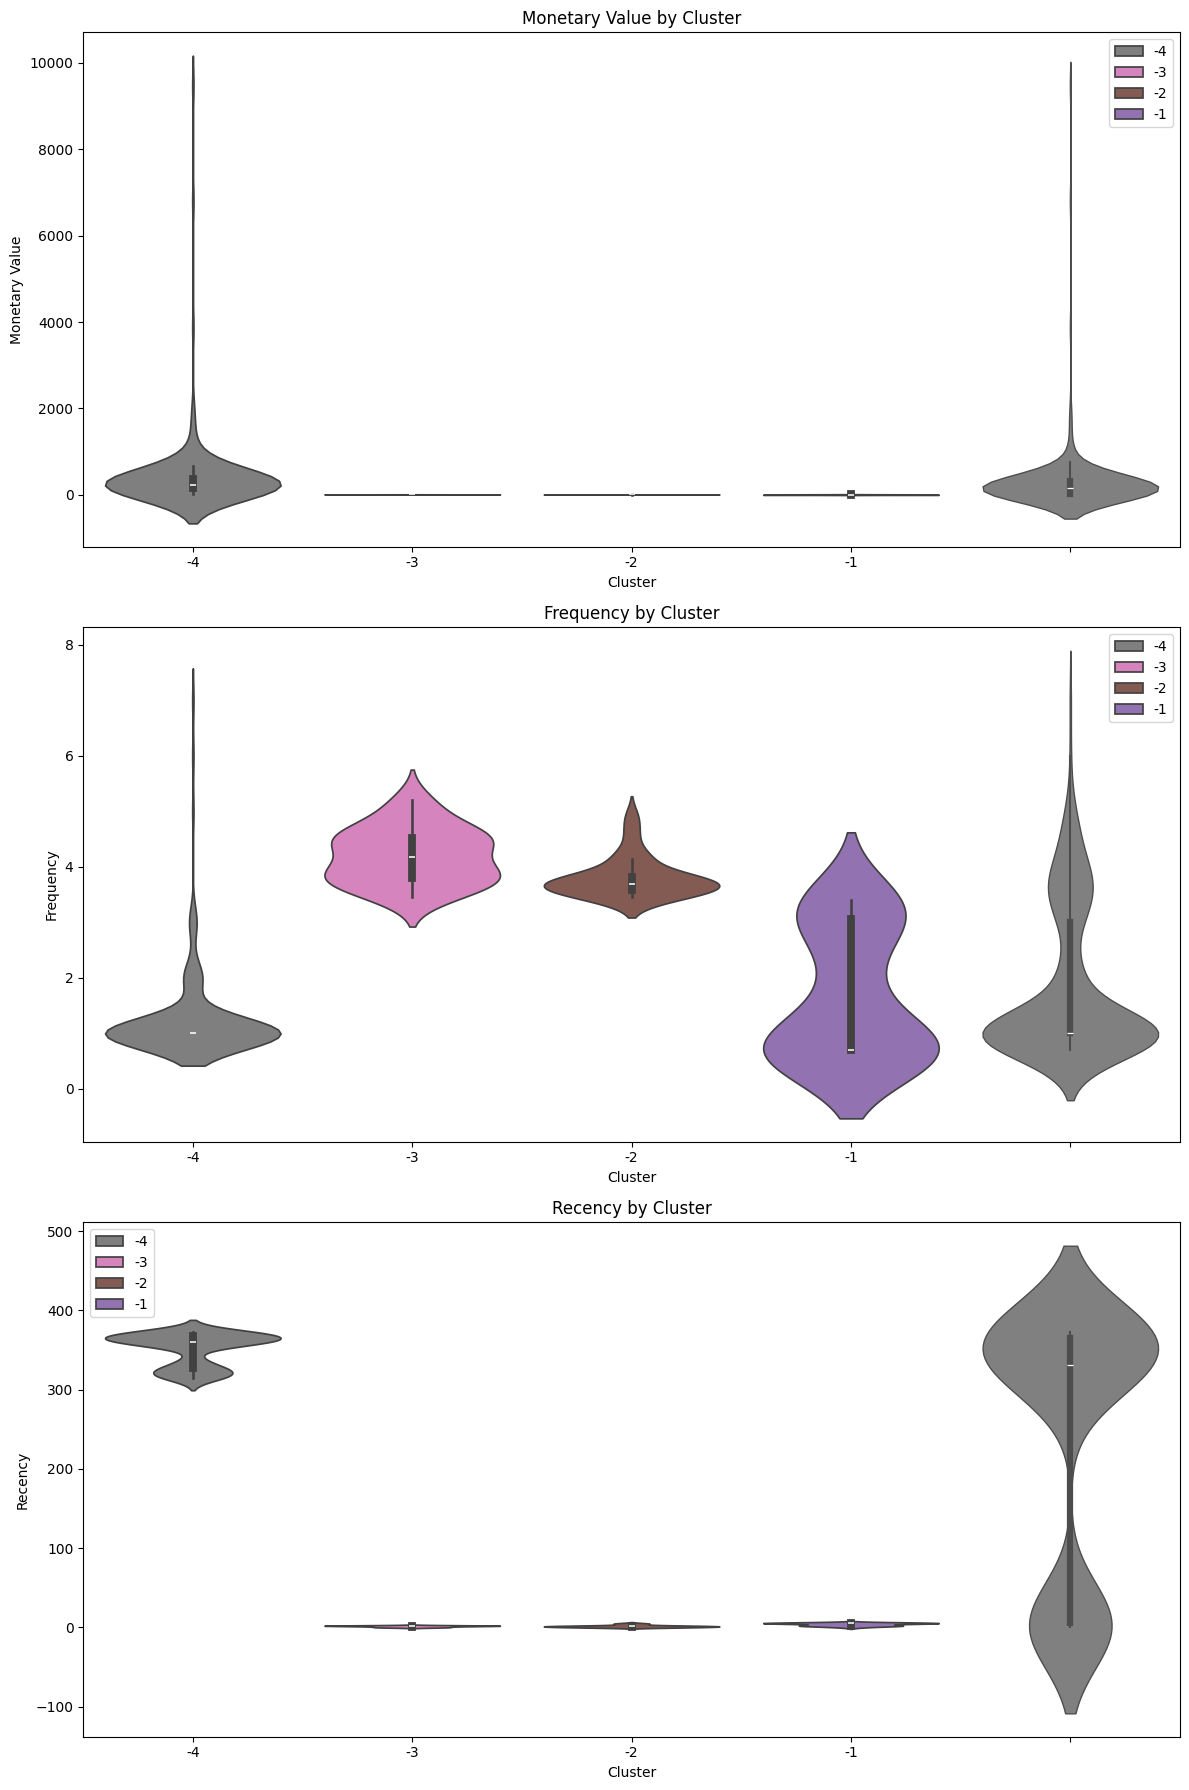

In [211]:
cluster_colors = {-1: '#9467bd',
                  -2: '#8c564b',
                  -3: '#e377c2',
                  -4: '#7f7f7f'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['MonetaryValue'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [212]:
cluster_labels = {
    0: "RETAIN",
    1: "RE-ENGAGE",
    2: "NURTURE",
    3: "REWARD",
    -1: "PAMPER",
    -2: "UPSELL",
    -3: "DELIGHT",
    -4: "REACTIVATE"

}



In [213]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

full_clustering_df



,Customer ID,MonetaryValue,Frequency,Recency,Tenure,Cluster,AOV
0,12346,5.14,1.10,5.11,4.78,3,NaN
1,12347,7.19,1.10,1.10,3.64,2,NaN
2,12348,5.40,0.69,4.30,0.00,1,NaN
3,12349,7.71,1.10,3.76,5.20,3,NaN
4,12351,5.71,0.69,2.40,0.00,1,NaN
...,...,...,...,...,...,...,...
4089,18012,115.30,1.00,358.00,0.00,-4,115.30
4194,18162,371.51,1.00,367.00,0.00,-4,371.51
4209,18186,329.58,1.00,357.00,0.00,-4,329.58
4220,18199,344.75,1.00,318.00,0.00,-4,344.75


In [214]:
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)

full_clustering_df



,Customer ID,MonetaryValue,Frequency,Recency,Tenure,Cluster,AOV,ClusterLabel
0,12346,5.14,1.10,5.11,4.78,3,NaN,REWARD
1,12347,7.19,1.10,1.10,3.64,2,NaN,NURTURE
2,12348,5.40,0.69,4.30,0.00,1,NaN,RE-ENGAGE
3,12349,7.71,1.10,3.76,5.20,3,NaN,REWARD
4,12351,5.71,0.69,2.40,0.00,1,NaN,RE-ENGAGE
...,...,...,...,...,...,...,...,...
4089,18012,115.30,1.00,358.00,0.00,-4,115.30,REACTIVATE
4194,18162,371.51,1.00,367.00,0.00,-4,371.51,REACTIVATE
4209,18186,329.58,1.00,357.00,0.00,-4,329.58,REACTIVATE
4220,18199,344.75,1.00,318.00,0.00,-4,344.75,REACTIVATE


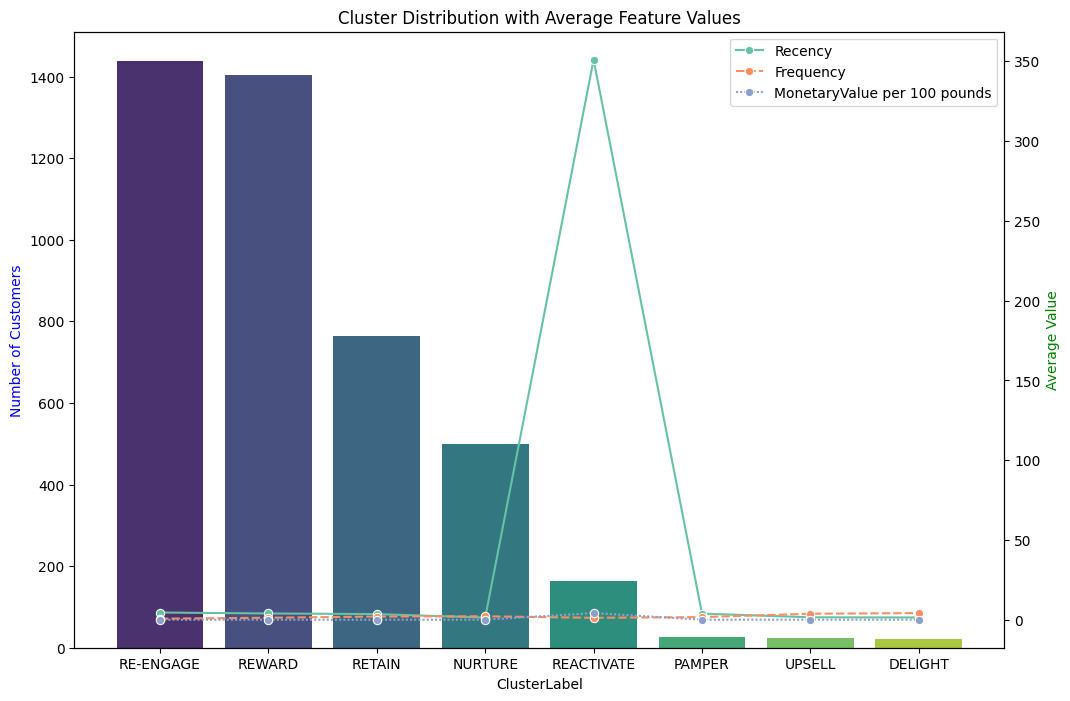

In [215]:
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()
full_clustering_df["MonetaryValue per 100 pounds"] = full_clustering_df["MonetaryValue"] / 100.00
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue per 100 pounds']].mean()

feature_means = feature_means.reindex(cluster_counts.index)

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()


sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()

